In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from  sklearn.metrics import r2_score

In [2]:
bigmart_df = pd.read_csv('bigmart.csv')

In [3]:
bigmart_df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [4]:
bigmart_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


In [7]:
bigmart_df['Item_Fat_Content'].value_counts()

Item_Fat_Content
Low Fat    5089
Regular    3434
Name: count, dtype: int64

In [6]:
def gr_fat_content(fat):
    if fat in ['Low Fat', 'Regular']:
        return fat
    elif fat == ['LF','low fat']:
        return 'Low Fat'
    else:
        return 'Regular'

bigmart_df['Item_Fat_Content'] = bigmart_df['Item_Fat_Content'].apply(lambda fat : gr_fat_content(fat))

In [8]:
bigmart_df['Outlet_Type'].value_counts()

Outlet_Type
Supermarket Type1    5577
Grocery Store        1083
Supermarket Type3     935
Supermarket Type2     928
Name: count, dtype: int64

# EDA

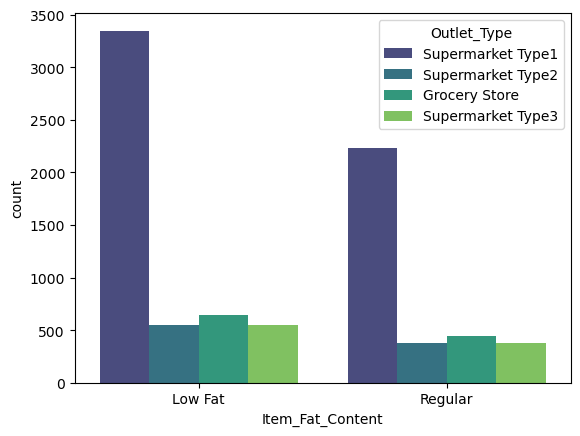

In [72]:
sns.countplot(data = bigmart_df, x = 'Item_Fat_Content', hue = 'Outlet_Type', palette='viridis');

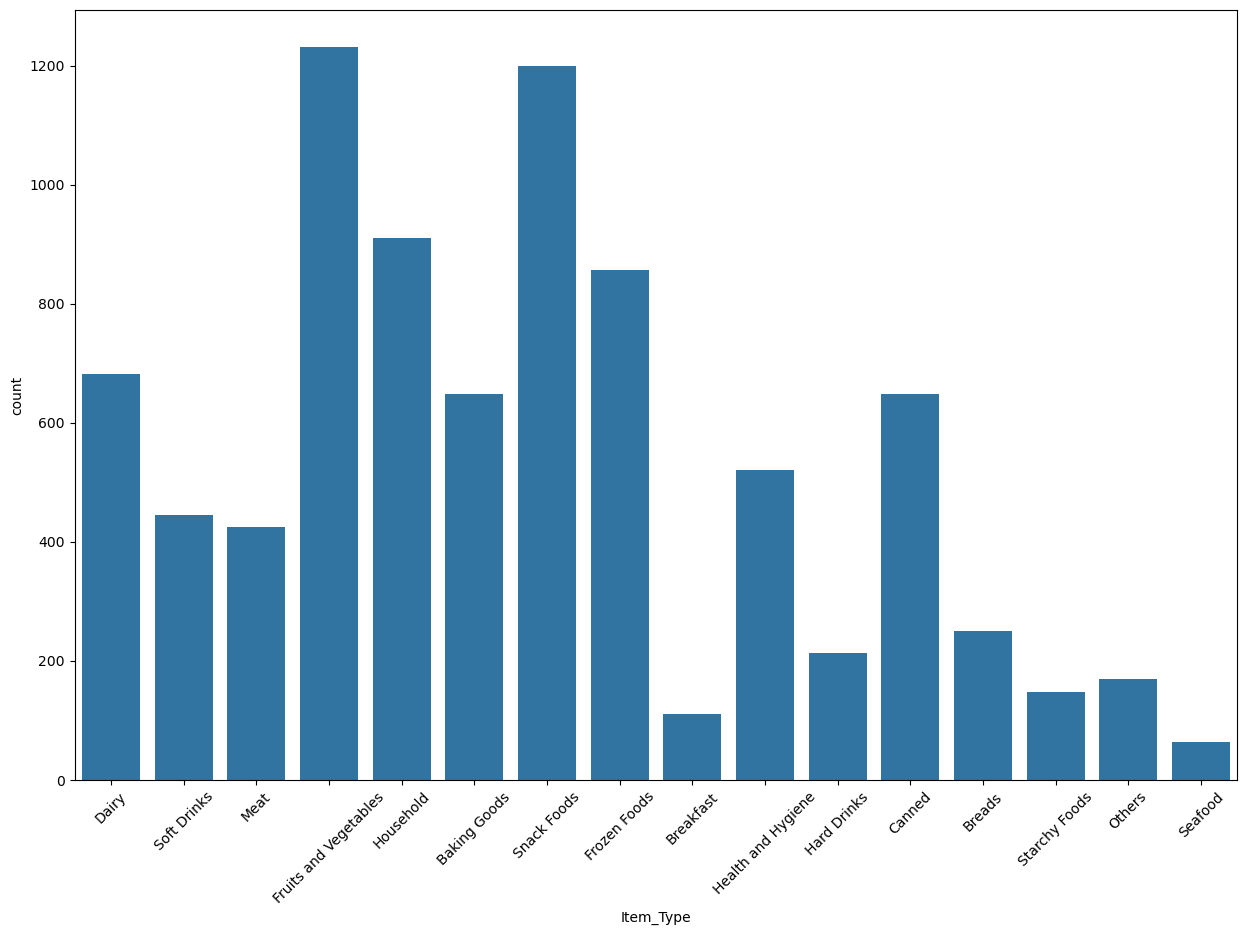

In [73]:
plt.subplots(figsize =(15,10))
sns.countplot(data = bigmart_df, x = 'Item_Type');
plt.xticks(rotation=45, fontsize=10);

In [74]:
bigmart_df['Item_Type'].value_counts()

Item_Type
Fruits and Vegetables    1232
Snack Foods              1200
Household                 910
Frozen Foods              856
Dairy                     682
Canned                    649
Baking Goods              648
Health and Hygiene        520
Soft Drinks               445
Meat                      425
Breads                    251
Hard Drinks               214
Others                    169
Starchy Foods             148
Breakfast                 110
Seafood                    64
Name: count, dtype: int64

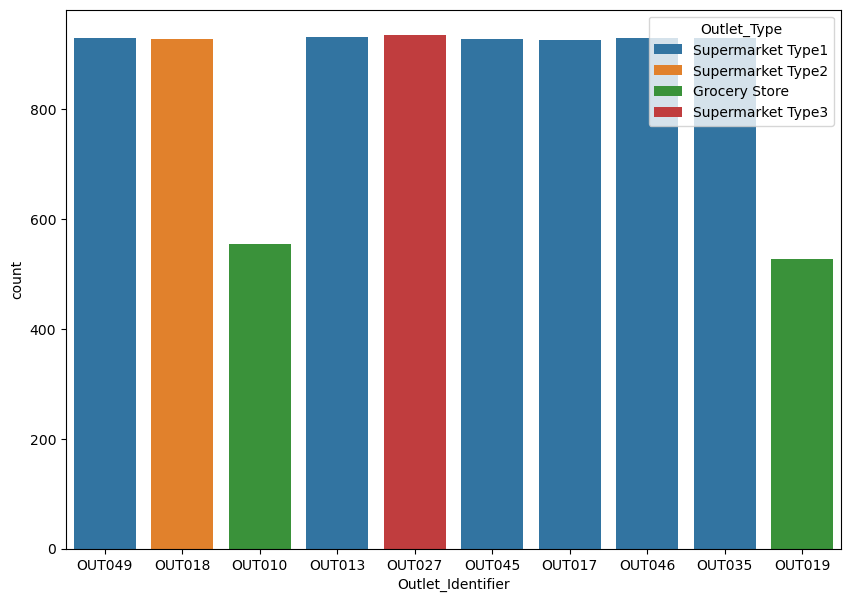

In [75]:
plt.subplots(figsize =(10,7))
sns.countplot(data = bigmart_df, x = 'Outlet_Identifier', hue = 'Outlet_Type');

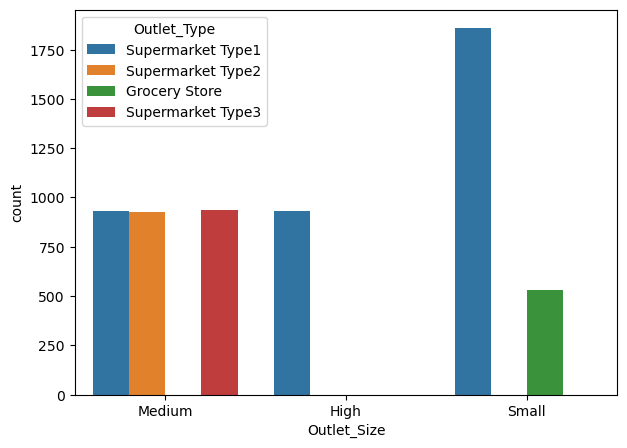

In [76]:
plt.subplots(figsize =(7,5))
sns.countplot(data = bigmart_df, x = 'Outlet_Size', hue = 'Outlet_Type');

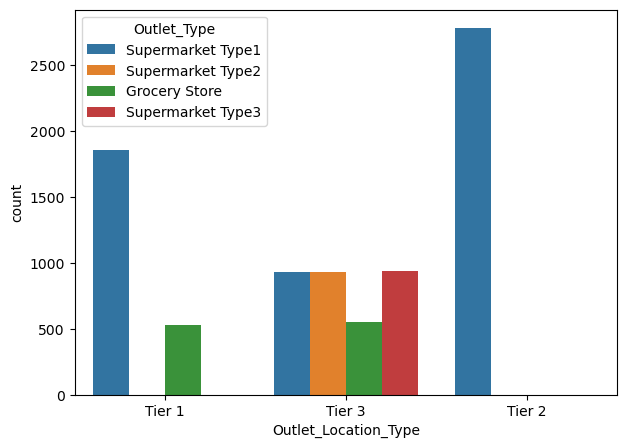

In [77]:
plt.subplots(figsize =(7,5))
sns.countplot(data = bigmart_df, x = 'Outlet_Location_Type', hue = 'Outlet_Type');

In [78]:
bigmart_df.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,7060.000000,8523.000000,8523.000000,8523.000000,8523.000000
mean,12.857645,0.066132,140.992782,1997.831867,2181.288914
std,4.643456,0.051598,62.275067,8.371760,1706.499616
min,4.555000,0.000000,31.290000,1985.000000,33.290000
25%,8.773750,0.026989,93.826500,1987.000000,834.247400
50%,12.600000,0.053931,143.012800,1999.000000,1794.331000
75%,16.850000,0.094585,185.643700,2004.000000,3101.296400
max,21.350000,0.328391,266.888400,2009.000000,13086.964800


# Preprocessing data

In [149]:
bigmart_df['Item_Identifier'].value_counts()

Item_Identifier
FDW13    10
FDG33    10
NCY18     9
FDD38     9
DRE49     9
         ..
FDY43     1
FDQ60     1
FDO33     1
DRF48     1
FDC23     1
Name: count, Length: 1559, dtype: int64

In [150]:
import re

def extract_title(item):
    k = re.compile(r"^.{2}")  # Lấy 2 ký tự đầu tiên của chuỗi
    match = k.search(item)
    if match:
        return match.group(0).strip()  # Lấy kết quả tìm thấy
    return None  # Trả về None nếu không tìm thấy

bigmart_df['Item_Iden'] = bigmart_df['Item_Identifier'].apply(lambda item: extract_title(item))

In [151]:
bigmart_df['Item_Iden'].value_counts()

Item_Iden
FD    6125
NC    1599
DR     799
Name: count, dtype: int64

In [152]:
num_feature = ['Item_Weight', 'Item_Visibility','Item_MRP','Outlet_Establishment_Year']
cat_feature = ['Item_Iden', 'Item_Fat_Content', 'Item_Type', 'Outlet_Identifier', 'Outlet_Size','Outlet_Location_Type', 'Outlet_Type']
feature_cols = num_feature + cat_feature
print(feature_cols)

['Item_Weight', 'Item_Visibility', 'Item_MRP', 'Outlet_Establishment_Year', 'Item_Iden', 'Item_Fat_Content', 'Item_Type', 'Outlet_Identifier', 'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type']


In [153]:
bigmart_df['Item_Weight'] = bigmart_df['Item_Weight'].fillna(bigmart_df['Item_Weight'].mean())

In [154]:
bigmart_df['Outlet_Size'] = bigmart_df['Outlet_Size'].fillna(bigmart_df['Outlet_Size'].mode()[0])

In [155]:
bigmart_df.isnull().sum()

Item_Identifier              0
Item_Weight                  0
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Identifier            0
Outlet_Establishment_Year    0
Outlet_Size                  0
Outlet_Location_Type         0
Outlet_Type                  0
Item_Outlet_Sales            0
Item_Iden                    0
dtype: int64

In [156]:
encoders = {}
for feature in cat_feature:
    le = LabelEncoder()
    bigmart_df[feature] = le.fit_transform(bigmart_df[feature])
    encoders[feature] = le

In [157]:
bigmart_df[cat_feature]

,Item_Iden,Item_Fat_Content,Item_Type,Outlet_Identifier,Outlet_Size,Outlet_Location_Type,Outlet_Type
0,1,0,4,9,1,0,1
1,0,1,14,3,1,2,2
2,1,0,10,9,1,0,1
3,1,1,6,0,1,2,0
4,2,0,9,1,0,2,1
...,...,...,...,...,...,...,...
8518,1,0,13,1,0,2,1
8519,1,1,0,7,1,1,1
8520,2,0,8,6,2,1,1
8521,1,1,13,3,1,2,2


In [158]:
X = bigmart_df[feature_cols]
y = bigmart_df['Outlet_Type']

In [170]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [171]:
xg_model = XGBRegressor()

In [172]:
xg_model.fit(X_train,y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [173]:
y_pred_train = xg_model.predict(X_train)
train_r2 = r2_score(y_pred_train,y_train)
print('R square vale', train_r2)

R square vale 1.0


In [174]:
y_pred_test = xg_model.predict(X_test)
test_r2 = r2_score(y_pred_test,y_test)
print('R square vale', test_r2)

R square vale 1.0


In [175]:
y_test = np.asarray(y_test)

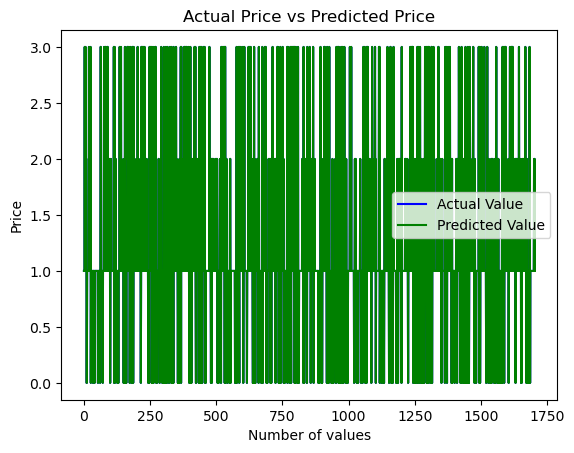

In [176]:
plt.plot(y_test, color = 'blue', label = 'Actual Value')
plt.plot(y_pred_test, color = 'green', label = 'Predicted Value')
plt.title('Actual Price vs Predicted Price')
plt.xlabel('Number of values')
plt.ylabel('Price')
plt.legend()
plt.show()

In [177]:
model = RandomForestRegressor()

In [178]:
model.fit(X_train,y_train)

RandomForestRegressor()

In [179]:
y_pred_train = xg_model.predict(X_train)
train_r2 = r2_score(y_pred_train,y_train)
print('R square vale', train_r2)

R square vale 1.0


In [180]:
y_pred_test = xg_model.predict(X_test)
test_r2 = r2_score(y_pred_test,y_test)
print('R square vale', test_r2)

R square vale 1.0
